In [147]:
IMAGE_W = 224
IMAGE_H = 152
IMAGE_D = 224

NR_SHARDS = 6

INPUT_FOLDER = '../../output/step3/'
OUTPUT_FOLDER = '../../output/step4/'

In [148]:
import sys
import h5py
from random import shuffle
import numpy as np
from numpy import ndarray
import pandas as pd
import statistics
import csv
import dicom
import math
from time import time
import os
import shutil
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage as ndimage
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import shift
import itertools
from itertools import product, combinations
from skimage import measure, morphology, transform
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [149]:
class Timer:
    def __init__(self, name, debug=True):
        self._name = name
        self._debug = debug
        self.start()
    
    def start(self):
        self._start = time()
        if(self._debug):
            log('> [started] ' + self._name + '...')

    def stop(self):
        self._lastElapsed = (time()-self._start)
        if(self._debug):
            log('> [done]    {} ({:.3f} ms)'.format(self._name, self._lastElapsed*1000))
            
    def elapsed(self):
        if(self._lastElapsed != None):
            return (self._lastElapsed)
        else:
            return (time()-self._start)
        
import datetime
def log(message):
    print('{} {}'.format(datetime.datetime.now(), message))


In [150]:
def show_image(pixels, slice_pos, patient_id):
    fig1, ax1 = plt.subplots(1)
    fig1.set_size_inches(4,4)
    ax1.imshow(pixels[round(np.shape(pixels)[0]*(slice_pos-1))], cmap=plt.cm.gray)
    
    if(SAVE_IMAGES):
        file = OUTPUT_FOLDER + 'images/' + patient_id + '-' + 'slice-' + str(slice_pos) + '.jpg'
        plt.savefig(file)
        plt.close(fig1)
    else:
        plt.show()


In [151]:
def show_slices(pixels, patient_id, nr_slices=12, cols=4):
    fig = plt.figure()
    slice_depth = round(np.shape(pixels)[0]/nr_slices)
    rows = round(nr_slices/cols)+1
    fig.set_size_inches(cols*10, rows*10)
    for i in range(nr_slices):
        slice_pos = int(slice_depth*i)
        y = fig.add_subplot(rows,cols,i+1)
        y.imshow(pixels[slice_pos], cmap='gray')
        
    if(SAVE_IMAGES):
        file = OUTPUT_FOLDER + 'images/' + patient_id + '-' + 'slices.jpg'
        plt.savefig(file)
        plt.close(fig)
    else:
        plt.show()


In [152]:
def show_slices(pixels, nr_slices=12, cols=4):
    fig = plt.figure()
    slice_depth = round(np.shape(pixels)[0]/nr_slices)
    rows = round(nr_slices/cols)+1
    fig.set_size_inches(cols*10, rows*10)
    for i in range(nr_slices):
        slice_pos = int(slice_depth*i)
        y = fig.add_subplot(rows,cols,i+1)
        y.imshow(pixels[slice_pos], cmap='gray')
    plt.show()


In [153]:
def validate_dataset(dataset_file):
    log('VALIDATING OUTPUT DATASET ' + dataset_file)

    with h5py.File(dataset_file, 'r') as h5f:
        x_ds = h5f['X']
        y_ds = h5f['Y']

        if(len(x_ds) != len(y_ds)):
            print('VALIDATION ERROR: x and y datasets with different lengths')

        for px in range(len(x_ds)):
            arr = np.array(x_ds[px])
            if(not np.any(arr)):
                print('VALIDATION ERROR: No image found index=', px)

        for py in range(len(y_ds)):
            arr = np.array(y_ds[py])
            if(not np.any(arr)):
                print('VALIDATION ERROR: No label found index=', py, 'label=', arr)

        print('X shape=', x_ds.shape)
        print('Y shape=', y_ds.shape)

        size = len(x_ds)
        qtty = min(10, size)
        f = size/qtty
        for i in range(qtty):
            pi = round(i*f)
            print('patient_index', pi)
            print('x=')
            show_slices(x_ds[pi])
            print('y=',y_ds[pi])


In [154]:
def start_processing(input_dir, nr_shards, image_w, image_h, image_d, output_dir):
    log('Merging shard results. nr_shards=' + str(nr_shards) + ' input_dir='+ str(input_dir) + ' output_dir=' + output_dir)
    
    t = Timer('Preparing output dir')
    shutil.rmtree(output_dir, True)
    try:
        os.makedirs(output_dir)
    except:
        print('Ops! Couldnt create output dir')
        pass
    t.stop()

    t = Timer('Count total patients among shards')
    total_patients = 0
    for shard_id in range(1,nr_shards+1):
        dataset_file = input_dir + '{}/data-centered-rotated-{}-{}-{}.h5'.format(shard_id, image_w, image_h, image_d)
        with h5py.File(dataset_file, 'r') as h5f:
            print('shard_id={} shape={}'.format(shard_id,h5f['X'].shape))
            total_patients = total_patients + len(h5f['X'])
    t.stop()
            
    log('total_patients=' + str(total_patients))

    t = Timer('Creating output merged dataset')
    output_dataset_file = output_dir + 'data-centered-rotated-{}-{}-{}.h5'.format(image_w, image_h, image_d)
    with h5py.File(output_dataset_file, 'w') as h5f:
        x_ds = h5f.create_dataset('X', (total_patients, image_d, image_h, image_w), chunks=(1, image_d, image_h, image_w), dtype='f')
        y_ds = h5f.create_dataset('Y', (total_patients, 2), dtype='f')

        log('Merging shards')
        pb = 0
        for shard_id in range(1,nr_shards+1):
            ts = Timer('Processing shard' + str(shard_id))
            dataset_file = input_dir + '{}/data-centered-rotated-{}-{}-{}.h5'.format(shard_id, image_w, image_h, image_d)
            with h5py.File(dataset_file, 'r') as sh5f:
                shard_x_ds = sh5f['X']
                shard_y_ds = sh5f['Y']
                le = len(shard_x_ds)
                pe = pb + le
                print('output', pb, pe, 'input', 0, le)
                x_ds[pb:pe] = shard_x_ds[0:le]
                y_ds[pb:pe] = shard_y_ds[0:le]
                pb = pe
            ts.stop()
    t.stop()
    
    t = Timer('Output dataset validations')
    validate_dataset(output_dataset_file)
    t.stop()

==== PROCESSING SHARDS MERGE ====
2017-02-19 04:17:12.121687 Merging shard results. nr_shards=2 input_dir=../../output/step3/ output_dir=../../output/step4/
2017-02-19 04:17:12.121736 > [started] Preparing output dir...
2017-02-19 04:17:12.127446 > [done]    Preparing output dir (5.684 ms)
2017-02-19 04:17:12.127511 > [started] Count total patients among shards...
shard_id=1 shape=(1, 224, 152, 224)
shard_id=2 shape=(1, 224, 152, 224)
2017-02-19 04:17:12.128798 > [done]    Count total patients among shards (1.279 ms)
2017-02-19 04:17:12.128831 total_patients=2
2017-02-19 04:17:12.128857 > [started] Creating output merged dataset...
2017-02-19 04:17:12.129668 Merging shards
2017-02-19 04:17:12.129713 > [started] Processing shard1...
output 0 1 input 0 1
2017-02-19 04:17:12.168572 > [done]    Processing shard1 (38.836 ms)
2017-02-19 04:17:12.168643 > [started] Processing shard2...
output 1 2 input 0 1
2017-02-19 04:17:12.202933 > [done]    Processing shard2 (34.274 ms)
2017-02-19 04:17:1

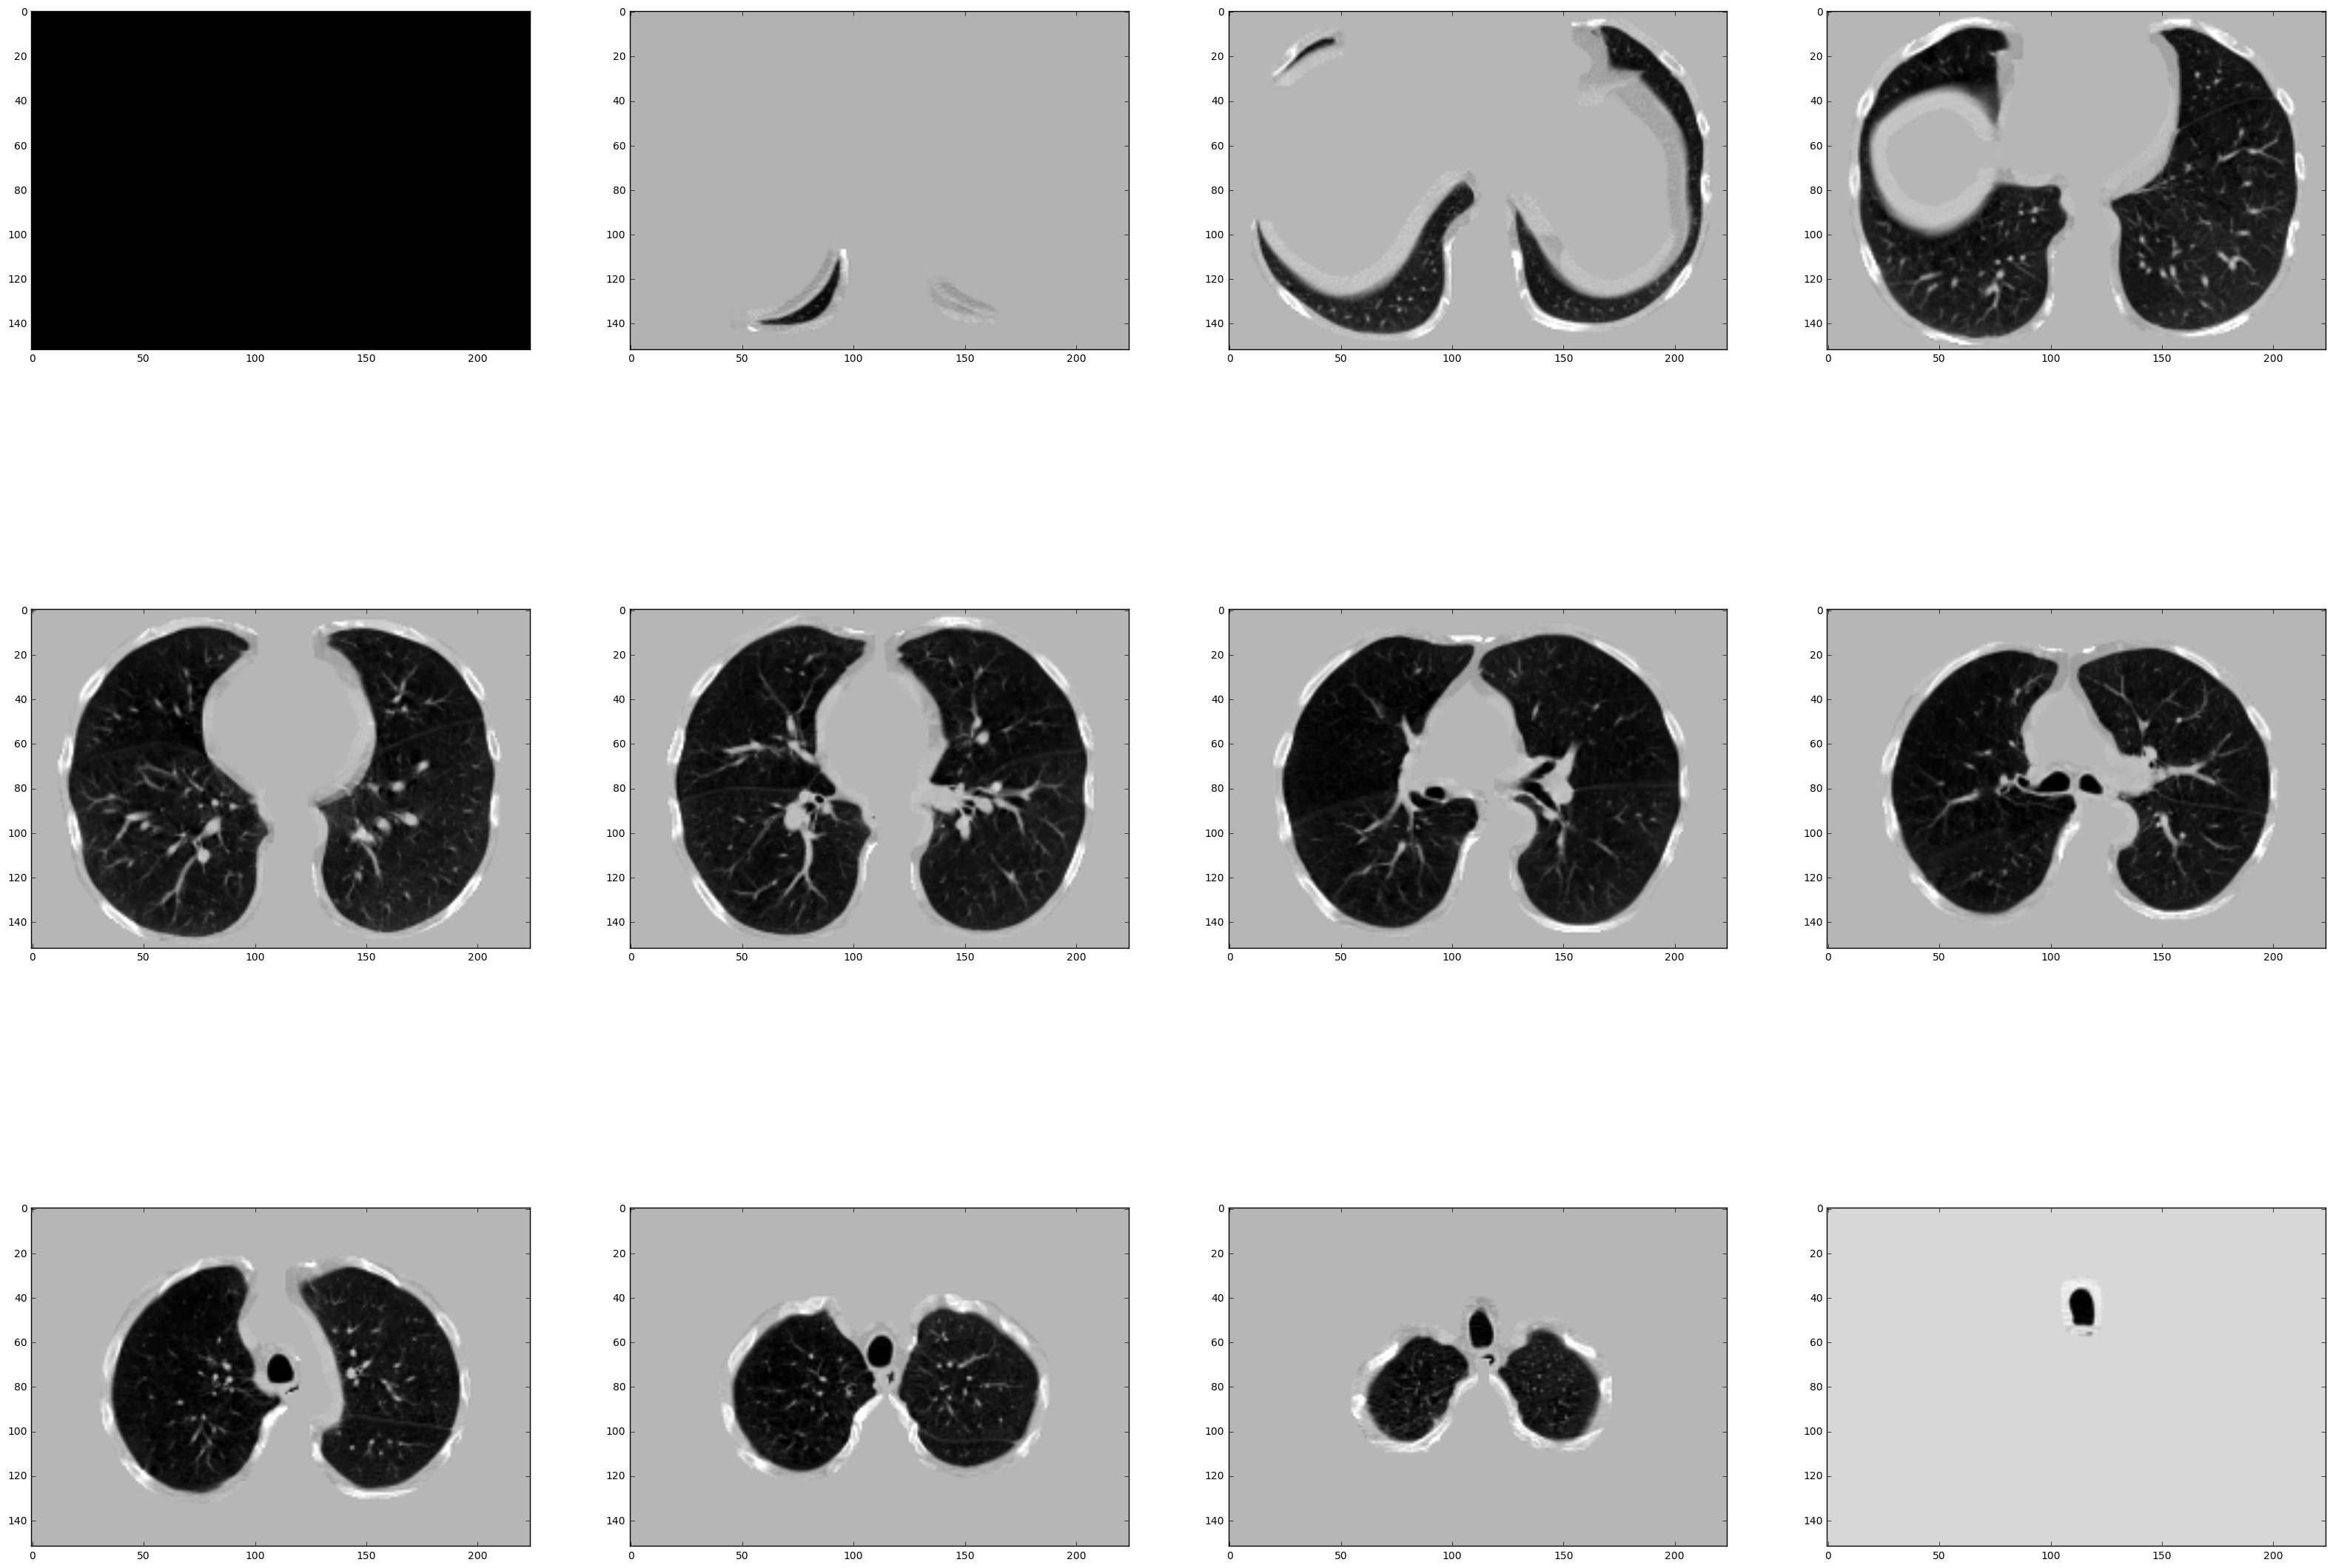

y= [ 0.  1.]
patient_index 1
x=


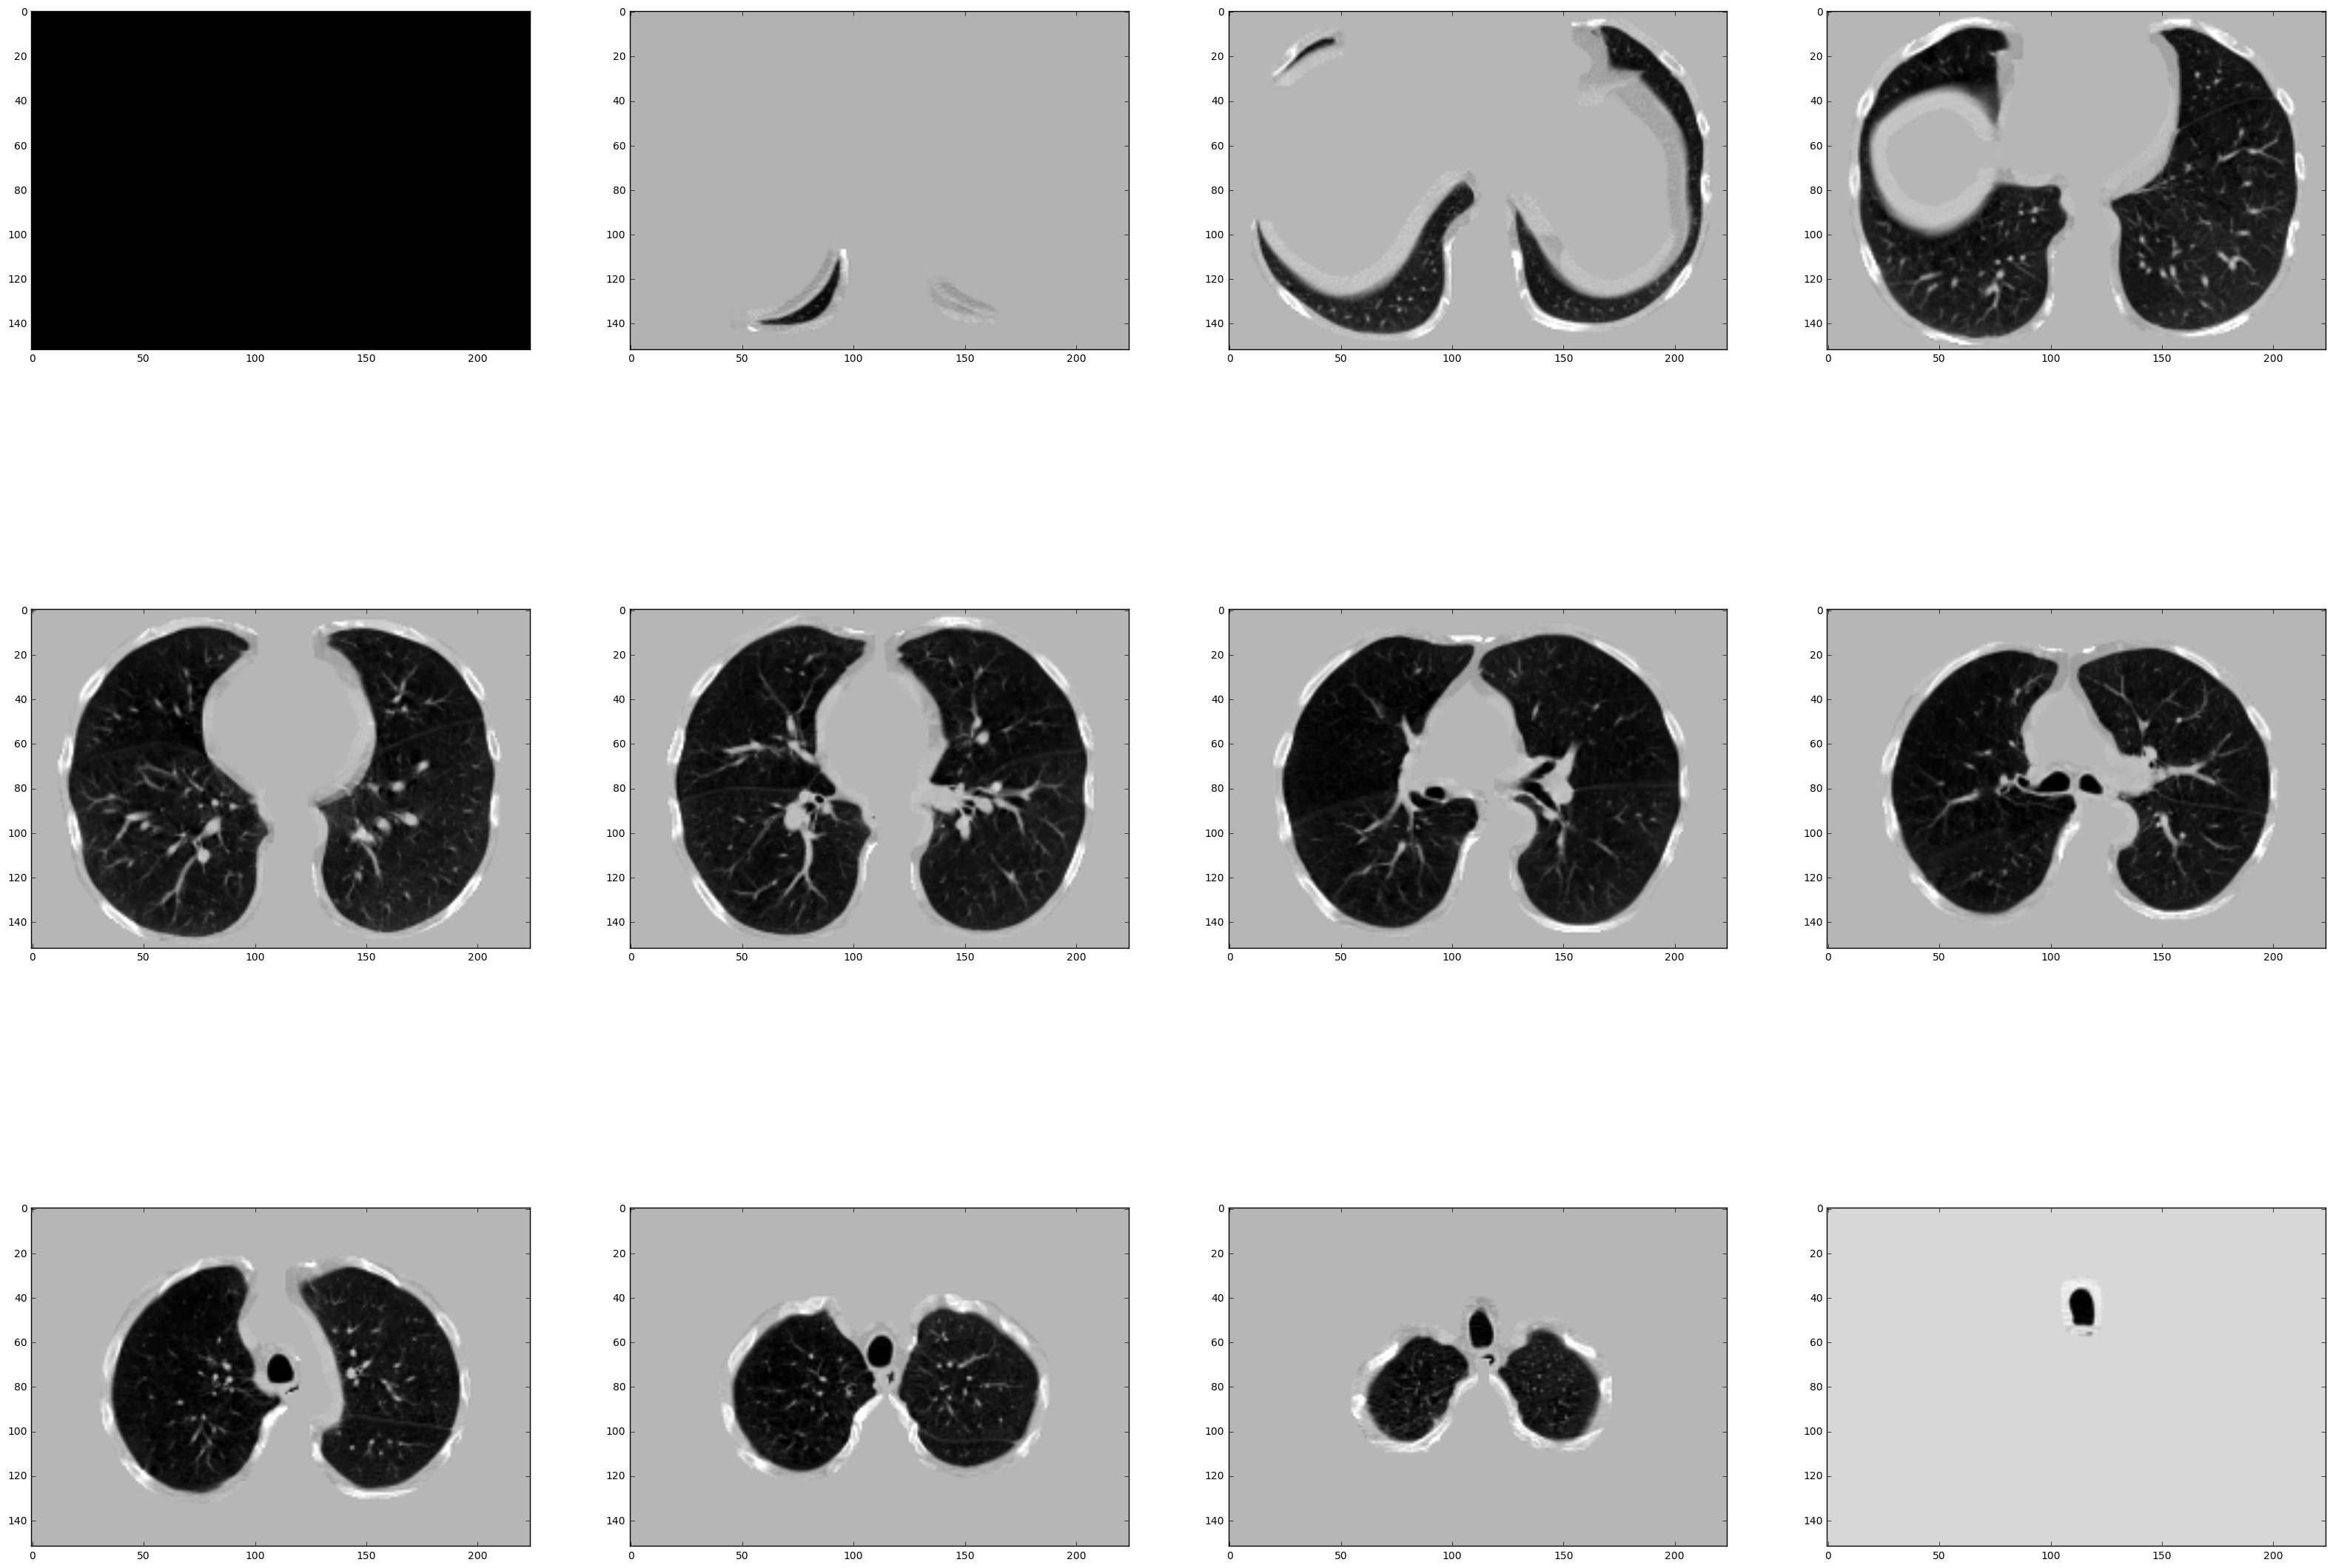

y= [ 0.  1.]
2017-02-19 04:17:22.361984 > [done]    Output dataset validations (10158.604 ms)
==== ALL DONE ====


In [155]:
print('==== PROCESSING SHARDS MERGE ====')
start_processing(INPUT_FOLDER, NR_SHARDS, IMAGE_W, IMAGE_H, IMAGE_D, OUTPUT_FOLDER)
print('==== ALL DONE ====')